
shall we try the BIDS scheme for all behavioral data as well? the HED seems quite elaborate and rather unintuitive to me: https://bids-specification.readthedocs.io/en/stable/99-appendices/03-hed.html#annotating-events-by-categories

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import itertools
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import shutil
import multiprocessing as mp
import re

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

In [2]:
#msit response buttons
# r = 1, g = 2 ,y = 3

In [2]:
class prepBehavior(object):
    ''' To run, simply prepBehavior(subject_n, session_n, task_name).process()
    
    The idea here is to extract/generate two types of files: 
    - One used to do proper behavioral analyses/modelling later on (a csv with a row per trial and many additional columns)
    - One used for the fMRI data analyses, which follows the bids convention (one row per event, with columns [onset, trial_type, duration])
    
    Which events need to be extracted for the fMRI data analyses will depend on the fMRI modelling later on. 
    Currently it extracts all event types (in the behavioral files) except for pulses; 
    but it takes no effort in categorizing stimuli or anything like that (so all stimuli types appear as "stimulus"). 
    The only exception are responses, which are mapped to response_left and response_right so we can easily
    check for lateralization in M1.
    
    - For the learning tasks, I coded up some plots as well to do a brief visual quality check.  
    '''
    
    def __init__(self, sub, ses, task, plot=True, sourcedata_dir='../sourcedata'):
        
        self.sub = sub
        self.ses = ses
        self.task = task
        self.plot = plot
        
        self.save_directories = {'events': '../derivatives/behavior/sub-{}/ses-{}/func'.format(self.sub, self.ses),
                                 'behavior': '../derivatives/event_files/sub-{}/ses-{}/func'.format(self.sub, self.ses)}
    
    def make_directories(self):
        for _, directory in self.save_directories.items():
            os.makedirs(directory, exist_ok=True)
    
    def find_event_files(self):
        #self.run_fns = sorted(glob.glob('../sourcedata/sub-{sub}/ses-{ses}/task*_data/sub-{sub}_*task-{task}*_block-*_events.tsv'.format(sub=self.sub, ses=self.ses, task=self.task)))
        #print(f'../sourcedata/zipdata/sub-{self.sub}/ses-{self.ses}/sub-{self.sub}_ses-{self.ses}_data_tmpunzip/RESOURCES/task*_data/sub-{self.sub}_*task-{self.task}*_block-*_events.tsv')
        self.run_fns = sorted(glob.glob(f'../sourcedata/zipdata/sub-{self.sub}/ses-{self.ses}/sub-{self.sub}_ses-{self.ses}_data_tmpunzip/sub-{self.sub}_ses-{self.ses}_data/RESOURCES/task*_data/sub-{self.sub}_*task-{self.task}*_block-*_events.tsv'))
        
        # sub 009 rbrevl task data saved weirdly, must manually input
        if self.sub == '009' and self.ses == 'rbrevl':
            if self.task == 'ReferenceBack':
                self.run_fns = ['../sourcedata/zipdata/sub-009/ses-rbrevl/sub-009_ses-rbrevl_data_tmpunzip/sub-009_ses-rbrevl_data/RESOURCES/task_data/sub-009_ses-MRI_task-ReferenceBack_datetime-20210302-083106_events.tsv',
                               '../sourcedata/zipdata/sub-009/ses-rbrevl/sub-009_ses-rbrevl_data_tmpunzip/sub-009_ses-rbrevl_data/RESOURCES/task_data/sub-009_ses-MRI_task-ReferenceBack_datetime-20210302-084621_events.tsv']
            elif self.task == 'reversal-learning':
                self.run_fns = ['../sourcedata/zipdata/sub-009/ses-rbrevl/sub-009_ses-rbrevl_data_tmpunzip/sub-009_ses-rbrevl_data/RESOURCES/task_data/sub-009_task-reversal-learning_datetime-20210302-075736_events.tsv',
                               '../sourcedata/zipdata/sub-009/ses-rbrevl/sub-009_ses-rbrevl_data_tmpunzip/sub-009_ses-rbrevl_data/RESOURCES/task_data/sub-009_task-reversal-learning_datetime-20210302-081521_events.tsv']
        
        if len(self.run_fns) == 0:
            raise IOError("No data file found for sub {} task {}".format(self.sub, self.task))
        
        self.make_directories() # only make directories if event files are found
        
    def load_run_events(self):
        ''' loads event data of all found runs '''
        self.data = []
        for fn in self.run_fns:
            print(fn)
            data = pd.read_csv(fn, sep='\t')
            ## NB: _events-files of blocks > 1 contain ALL data, so the event file of block 3 also contains blocks 1 and 2
            # hence, we need to find the last pulse with phase = -1, which marks the beginning of the run
            if self.task == 'SST':
                
                ### SM added this ##
                last_block_start_idx = np.where(data['event_type'] == 'non_response_keypress')[0][-1]  # cut on last space
                data = data.iloc[last_block_start_idx:].reset_index(drop=True)

                first_pulse_idx = np.where((data['event_type'] == 'pulse') & pd.isnull(data.phase))[0][0]  # cut on first pulse, which marks the start of the block
                data = data.iloc[first_pulse_idx:].reset_index(drop=True)
                
                ### which used to be this, but this forgot about the dummy volumes
#                indx_last_block_start = np.where(np.isnan(data.phase))[0][-1]
#                data = data.loc[indx_last_block_start:].reset_index(drop=True)
                data['correct_response_direction'] = data.direction
                #data = data.rename(columns={'correct_response': 'correct_response_direction'})
                self.data.append(data)
            elif self.task == 'MSIT':
                
#                 last_block_start_idx = np.where(data['event_type'] == 'non_response_keypress')[0][-1]  # cut on last space
                last_block_start_idx = np.where((data['event_type'] == 'non_response_keypress') & (data['response'] == 'space'))[0][-1]
                data = data.iloc[last_block_start_idx:].reset_index(drop=True)
                first_pulse_idx = np.where((data['event_type'] == 'pulse') & pd.isnull(data.phase))[0][0]  # cut on first pulse, which marks the start of the block
                data = data.iloc[first_pulse_idx:].reset_index(drop=True)
                
                ### which used to be this, but this forgot about the dummy volumes
#                indx_last_block_start = np.where(np.isnan(data.phase))[0][-1]
#                data = data.loc[indx_last_block_start:].reset_index(drop=True)
#                 data['correct_response_direction'] = data.direction
                data['correct_response_direction'] = data.correct_response
                #data = data.rename(columns={'correct_response': 'correct_response_direction'})
                self.data.append(data)
                
#                 indx_last_block_start = np.where(np.isnan(data.phase))[0][-1]
#                 data = data.loc[indx_last_block_start:].reset_index(drop=True)
#                 data['correct_response_direction'] = data.correct_response
#                 #data = data.rename(columns={'correct_response': 'correct_response_direction'})
#                 self.data.append(data)
            else:
                indx_last_block_start = np.where(data.phase == -1)[0][-1]
                data = data.loc[indx_last_block_start:].reset_index(drop=True)
                data = data.rename(columns={'correct_response': 'correct_response_direction'})
                self.data.append(data)
    
    def process_learning_run(self, data):
        
        # collect trials: take 'response' event whenever present in that trial, otherwise take 'stimulus'
        trials_with_responses = data.loc[(data['event_type'] == 'response') & (pd.notnull(data['rt_too_slow']))]  # the latter gets rid of secondary button presses
        trials_with_responses_idx = trials_with_responses['trial_nr'].unique()

        trials_with_stimuli_idx = data.loc[data['event_type'] == 'stimulus', 'trial_nr'].unique()
        trials_without_responses_idx = trials_with_stimuli_idx[~np.in1d(trials_with_stimuli_idx, trials_with_responses_idx)]
        trials_without_responses = data.loc[(data['event_type'] == 'stimulus') & (data['trial_nr'].isin(trials_without_responses_idx))]
#         trials_without_responses = data.loc[data['trial_nr'].isin(trials_without_responses_idx)]

#         trials_without_responses = data.loc[data.trial_nr.isin(trials_without_responses_idx)]
        
        trials_stim_response = pd.concat([trials_with_responses, trials_without_responses], axis=0).sort_values('onset')

        ## useful columns
        trials_stim_response = trials_stim_response[['block_nr', 'trial_nr', 'event_type', 'onset', 'response', 'stimulus_symbol_left', 'stimulus_symbol_right', 'correct_response_direction', 'p_win_left', 'p_win_right', 'rt', 'choice_direction', 'choice_outcome', 'cue']]
        trials_stim_response.correct_response_direction = trials_stim_response.correct_response_direction.replace({0: 'left', 1: 'right'}).astype('category')
        trials_stim_response.choice_direction = trials_stim_response.choice_direction.replace({0: 'left', 1: 'right'}).astype('category')
        trials_stim_response['ease'] = np.round(np.abs(trials_stim_response['p_win_left']-trials_stim_response['p_win_right']),3) ## difficulty inverted
        trials_stim_response['accuracy'] = trials_stim_response['choice_direction'] == trials_stim_response['correct_response_direction']
        
#         responses = data.loc[data.event_type == 'response', ['block_nr', 'trial_nr', 'onset', 'response', 'stimulus_symbol_left', 'stimulus_symbol_right', 'correct_response_direction', 'p_win_left', 'p_win_right', 'rt', 'choice_direction', 'choice_outcome', 'cue']]
#         responses.correct_response_direction = responses.correct_response_direction.replace({0: 'left', 1: 'right'}).astype('category')
#         responses.choice_direction = responses.choice_direction.replace({0: 'left', 1: 'right'}).astype('category')
#         responses['ease'] = np.round(np.abs(responses['p_win_left']-responses['p_win_right']),3) ## difficulty inverted
#         responses['accuracy'] = responses['choice_direction'] == responses['correct_response_direction']
        
        return trials_stim_response
    
    def process_sst_run(self, data):

        data['onset'] = data['onset'] - data.loc[data['event_type']=='pulse','onset'].values[0]
        data = data.loc[(data.event_type!='pulse')]         # remove pulses
        data = data.loc[~pd.isnull(data['trial_nr'])]       # remove stuff without trial numbers
        data = data.loc[data.event_type.isin(['stimulus', 'response'])]  # only stim & responses
        data = data.loc[(data.null_trial == 0)]             # remove null trials
        data = data.loc[(data.phase == 1)]                  # Only include responses given in phase 1
        ## find trials with responses
        has_response = data.groupby('trial_nr')['choice_key'].apply(lambda x: np.any(pd.notnull(x)))
        has_response.name = 'has_response'
        data = pd.merge(data, has_response, left_on='trial_nr', right_index=True)  # merge back in
        # make is correct column
        data['correct'] = np.nan
        data.loc[(data.direction == 1) & (data.choice_key == 'r'), 'correct'] = 1
        data.loc[(data.direction == 0) & (data.choice_key == 'b'), 'correct'] = 1
        is_correct = data.groupby('trial_nr')['correct'].apply(lambda x: np.any(pd.notnull(x)))
        is_correct.name = 'is_correct'
        data = pd.merge(data, is_correct, left_on='trial_nr', right_index=True)  # merge back in
        # categorize fs / ss /go /gf
        data['trial_type'] = np.nan
        data.loc[(data['stopsig_trial'] == 1) & (data['has_response'] == 1) , 'trial_type'] = 'fs'
        data.loc[(data['stopsig_trial'] == 1) & (data['has_response'] == 0), 'trial_type'] = 'ss'
        data.loc[(data['stopsig_trial'] == 0), 'trial_type'] = 'go'
        data.loc[(data['stopsig_trial'] == 0) & (data['has_response'] == 0), 'trial_type'] = 'gf'
        data['correct'] = 0
        data.loc[(data.direction == 1) & (data.choice_key == 'r'), 'correct'] = 1
        data.loc[(data.direction == 0) & (data.choice_key == 'b'), 'correct'] = 1
        data.loc[(data['stopsig_trial'] == 0) & (data['has_response'] == 1) & (data['is_correct'] == False), 'trial_type'] = 'go_INC'
        # categorize response left / response right
        data = pd.merge(data, data.loc[data.event_type=='response', ['trial_nr', 'rt']], on='trial_nr', how='outer')
        data.loc[(data['event_type'] == 'response') & (data.response == 'b'), 'trial_type'] = 'response_right'
        data.loc[(data['event_type'] == 'response') & (data.response == 'r'), 'trial_type'] = 'response_left'
        responses = data
#         print(responses)
        
        return responses
        
    def process_msit_run(self, data):
#         data['accuracy'] = 0
#         data.loc[(data.correct_response == 1.0) & (data.choice_key == 'r'),'accuracy'] = 1
#         data.loc[(data.correct_response == 2.0) & (data.choice_key == 'g'),'accuracy'] = 1
#         data.loc[(data.correct_response == 3.0) & (data.choice_key == 'y'),'accuracy'] = 1
        if self.sub =='025':
            data.event_type[data.response=='b'] = 'response'
        responses = data.loc[data.event_type == 'response', ['block_nr', 'trial_nr', 'onset', 'response', 'stimuli', 'condition', 'choice_key', 'rt','correct_response']]
        responses.correct_response = responses.correct_response.replace({1: 'index', 2: 'middle', 3:'ring'}).astype('category')
        if self.sub =='025':
            print('subject 025')
            responses.choice_key[responses.response=='b'] = 'b'
            print(responses.choice_key)
            responses.choice_key = responses.choice_key.replace({'g': 'index', 'y': 'middle', 'b':'ring'}).astype('category')
        else:
            responses.choice_key = responses.choice_key.replace({'r': 'index', 'g': 'middle', 'y':'ring'}).astype('category')
        print(responses.correct_response)
        print(responses.choice_key)
        responses['accuracy'] = responses['choice_key'] == responses['correct_response']
        
        return responses
    
    def process_rb_run(self,data):
            
        data['WMstim'] = data['WMstim'].ffill()
        data['stimulus'] = data['stimulus'].ffill()
        data['color'] = data['color'].ffill()
        
        data['onset'] = data['onset'] - data.loc[data['event_type']=='pulse','onset'].values[0]
   
        data = data.loc[data.event_type.isin(['stimulus','response'])]
        stimuli_idx = data.event_type == 'stimulus'

        # Previous color?
        data.loc[stimuli_idx,'prev_color'] = np.nan
        data.loc[stimuli_idx,'prev_color'] = data.loc[stimuli_idx,'color'].shift(1)
        
        data['choice_outcome'] = np.nan
        data.loc[(data['stimulus'] == data['WMstim']) & (data['choice_key'] == 'b'), 'choice_outcome'] = 1.0 #correct match
        data.loc[(data['stimulus'] != data['WMstim']) & (data['choice_key'] == 'r'), 'choice_outcome'] = 1.0 #correct mismatch
        data.loc[(data['stimulus'] != data['WMstim']) & (data['choice_key'] == 'b'), 'choice_outcome'] = 0.0 #incorrect match
        data.loc[(data['stimulus'] == data['WMstim']) & (data['choice_key'] == 'r'), 'choice_outcome'] = 0.0 #incorrect mismatch

        # Switch or repeat?
        data.loc[stimuli_idx&(data['color'] == data['prev_color']), 'switch'] = 'repeat'
        data.loc[stimuli_idx&(data['color'] != data['prev_color']), 'switch'] = 'switch'
        
        data['accuracy'] = data['choice_outcome'] == 1.0
        data.loc[pd.isnull(data['choice_outcome']), 'accuracy'] = np.nan 
        data['accuracy'] = data['accuracy'].bfill()

        data.loc[(data['trial_nr'] == 0) | (data['trial_nr'] == 129), 'accuracy'] = np.nan


        data['trial_type'] = np.nan
        data.loc[(data['color'] == 'red') & (data['switch'] == 'repeat') & (data['stimulus'] == data['WMstim']), 'trial_type'] = 'RefRepSame' 
        data.loc[(data['color'] == 'red') & (data['switch'] == 'repeat') & (data['stimulus'] != data['WMstim']), 'trial_type'] = 'RefRepDifferent' 
        data.loc[(data['color'] == 'red') & (data['switch'] == 'switch') & (data['stimulus'] == data['WMstim']), 'trial_type'] = 'RefSwiSame' 
        data.loc[(data['color'] == 'red') & (data['switch'] == 'switch') & (data['stimulus'] != data['WMstim']), 'trial_type'] = 'RefSwiDifferent' 
        data.loc[(data['color'] == 'blue') & (data['switch'] == 'repeat') & (data['stimulus'] == data['WMstim']), 'trial_type'] = 'ComRepSame' 
        data.loc[(data['color'] == 'blue') & (data['switch'] == 'repeat') & (data['stimulus'] != data['WMstim']), 'trial_type'] = 'ComRepDifferent' 
        data.loc[(data['color'] == 'blue') & (data['switch'] == 'switch') & (data['stimulus'] == data['WMstim']), 'trial_type'] = 'ComSwiSame' 
        data.loc[(data['color'] == 'blue') & (data['switch'] == 'switch') & (data['stimulus'] != data['WMstim']), 'trial_type'] = 'ComSwiDifferent' 
        data.loc[(data['trial_nr'] == 0) | (data['trial_nr'] == 129), 'trial_type'] = np.nan
        #copy trial_type column for behavioral analyses (before removing trial information for incorrect trials)
        data['condition'] = data['trial_type'].ffill()
        data.loc[(data['trial_nr'] == 0) | (data['trial_nr'] == 129), 'condition'] = np.nan

        # code error trials
        data.loc[(data.event_type=='stimulus') & (data.accuracy == False), 'trial_type'] = 'error'

    
        data.loc[(data.event_type=='response') & (data.choice_direction == 0), 'trial_type'] = 'response_left'
        data.loc[(data.event_type=='response') & (data.choice_direction == 1), 'trial_type'] = 'response_right'
        
        data['switch'] = data['switch'].ffill()
        data['prev_color'] = data['prev_color'].ffill()

        
        # code error trials rather than left/right
        #data.loc[(data.event_type=='response') & (data.choice_outcome == 0), 'trial_type'] = 'error'
        #data.loc[(data.event_type=='response') & (data.choice_outcome == 1), 'trial_type'] = 'correct'


        data = data.loc[~((pd.isnull(data['trial_type']))&(data.event_type=='response'))]
      #  data['accuracy'] = data['choice_direction'] == data['correct_response_direction']
       # data.loc[(data['trial_nr'] == 0) | (data['trial_nr'] == 129), 'accuracy'] = np.nan
        data.loc[(data['trial_nr'] == 0) | (data['trial_nr'] == 129), 'choice_outcome'] = np.nan
#         trials_stim_response['accuracy'] = trials_stim_response['choice_direction'] == trials_stim_response['correct_response_direction']
    
        #data['accuracy'] = np.nan
        #data.loc[(data['choice_outcome'] == 1.0), 'accuracy'] = 
        
        return data

        # Old below
    # collect trials: take 'response' event whenever present in that trial, otherwise take 'stimulus'
#         trials_with_responses = data.loc[(data['event_type'] == 'response') & (pd.notnull(data['rt']))]  # the latter gets rid of secondary button presses
#         trials_with_responses_idx = trials_with_responses['trial_nr'].unique()
        
#         trials_with_responses['choice_outcome'] = np.nan
#         trials_with_responses.loc[(trials_with_responses['stimulus'] == trials_with_responses['WMstim']) & (trials_with_responses['choice_key'] == 'b'), 'choice_outcome'] = 1.0 #correct match
#         trials_with_responses.loc[(trials_with_responses['stimulus'] != trials_with_responses['WMstim']) & (trials_with_responses['choice_key'] == 'r'), 'choice_outcome'] = 1.0 #correct mismatch
#         trials_with_responses.loc[(trials_with_responses['stimulus'] != trials_with_responses['WMstim']) & (trials_with_responses['choice_key'] == 'b'), 'choice_outcome'] = 0.0 #incorrect match
#         trials_with_responses.loc[(trials_with_responses['stimulus'] == trials_with_responses['WMstim']) & (trials_with_responses['choice_key'] == 'r'), 'choice_outcome'] = 0.0 #incorrect mismatch
#         #trials_with_responses['prev_color'] = np.nan

        
#         trials_with_responses['correct_response_direction'] = np.nan
#         trials_with_responses.loc[(trials_with_responses['stimulus'] == trials_with_responses['WMstim']), 'correct_response_direction'] = 1 # match --> right
#         trials_with_responses.loc[(trials_with_responses['stimulus'] != trials_with_responses['WMstim']), 'correct_response_direction'] = 0 # mismatch --> left
       

#         trials_with_stimuli_idx = data.loc[data['event_type'] == 'stimulus', 'trial_nr'].unique()
        
    
#         trials_without_responses_idx = trials_with_stimuli_idx[~np.in1d(trials_with_stimuli_idx, trials_with_responses_idx)]
#         trials_without_responses = data.loc[(data['event_type'] == 'stimulus') & (data['trial_nr'].isin(trials_without_responses_idx))]
         
#         trials_stim_response = pd.concat([trials_with_responses, trials_without_responses], axis=0).sort_values('onset')
          
#         trials_stim_response['prev_color'] = np.nan
#         trials_stim_response['prev_color'] = trials_stim_response['color'].shift(1)
    
#         trials_with_responses['switch'] = np.nan
#         trials_stim_response.loc[(trials_stim_response['color'] == trials_stim_response['prev_color']), 'switch'] = 'repeat'
#         trials_stim_response.loc[(trials_stim_response['color'] != trials_stim_response['prev_color']), 'switch'] = 'switch'

        
#         trials_stim_response['trial_type'] = np.nan
#         trials_stim_response.loc[(trials_stim_response['color'] == 'red') & (trials_stim_response['switch'] == 'repeat') & (trials_stim_response['stimulus'] == trials_stim_response['WMstim']), 'trial_type'] = 'RefRepSame' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'red') & (trials_stim_response['switch'] == 'repeat') & (trials_stim_response['stimulus'] != trials_stim_response['WMstim']), 'trial_type'] = 'RefRepDifferent' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'red') & (trials_stim_response['switch'] == 'switch') & (trials_stim_response['stimulus'] == trials_stim_response['WMstim']), 'trial_type'] = 'RefSwiSame' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'red') & (trials_stim_response['switch'] == 'switch') & (trials_stim_response['stimulus'] != trials_stim_response['WMstim']), 'trial_type'] = 'RefSwiDifferent' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'blue') & (trials_stim_response['switch'] == 'repeat') & (trials_stim_response['stimulus'] == trials_stim_response['WMstim']), 'trial_type'] = 'ComRepSame' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'blue') & (trials_stim_response['switch'] == 'repeat') & (trials_stim_response['stimulus'] != trials_stim_response['WMstim']), 'trial_type'] = 'ComRepDifferent' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'blue') & (trials_stim_response['switch'] == 'switch') & (trials_stim_response['stimulus'] == trials_stim_response['WMstim']), 'trial_type'] = 'ComSwiSame' 
#         trials_stim_response.loc[(trials_stim_response['color'] == 'blue') & (trials_stim_response['switch'] == 'switch') & (trials_stim_response['stimulus'] != trials_stim_response['WMstim']), 'trial_type'] = 'ComSwiDifferent' 
#         trials_stim_response.loc[(trials_stim_response['trial_nr'] == 0) | (trials_stim_response['trial_nr'] == 129), 'trial_type'] = np.nan

# #         # trials_with_responses.loc[(trials_with_responses['color'] == 'blue') & (trials_with_responses['switch'] == 'switch') & (trials_with_responses['choice_key'] == 'r'), 'trial_type'] = 'ComSwiDifferent' 

        
#         ## useful columns
#         trials_stim_response = trials_stim_response[['block_nr', 'trial_nr', 'event_type', 'onset', 'response', 'stimulus', 'color', 'prev_color','WMstim','choice_key', 'rt', 'choice_direction', 'correct_response_direction','choice_outcome', 'switch', 'trial_type']]
        
#         trials_stim_response.correct_response_direction = trials_stim_response.correct_response_direction.replace({0: 'left', 1: 'right'}).astype('category')
#         trials_stim_response.choice_direction = trials_stim_response.choice_direction.replace({0: 'left', 1: 'right'}).astype('category')
#        # trials_stim_response['ease'] = np.round(np.abs(trials_stim_response['p_win_left']-trials_stim_response['p_win_right']),3) ## difficulty inverted
#         trials_stim_response['accuracy'] = trials_stim_response['choice_direction'] == trials_stim_response['correct_response_direction']
       
#         return trials_stim_response
    
    def plot_learning(self, responses, f=None, ax=None):
        if f is None:
            f, ax = plt.subplots(2,2, figsize=(8,5))

        _ = [ax_.grid() for ax_ in ax.ravel()]

        all_eases = sorted(responses.ease.unique())
        color_map = {'0.2': 'red',
                     '0.4': 'blue',
                     '0.6': 'green',
                     'SPD': 'darkred',
                     'ACC': 'darkgreen',
                     '': 'orange'}
        
        all_cues = sorted(responses.cue.unique())
        if len(all_cues) == 1:
            all_cues = ['']
        responses.loc[pd.isnull(responses.cue), 'cue'] = ''
        
        ## by cue (or overall)
        for cue in all_cues:
            for accuracy in [True, False]:
                rts = responses.loc[(responses.accuracy==accuracy) & (responses.cue==cue), 'rt']
                rts = rts * 1 if accuracy else rts*-1
                sns.histplot(rts, color=color_map[cue], ax=ax[0,0], kde=True, label='Accuracy = {:.2f}'.format(responses.accuracy.mean()) if (accuracy and cue == 'SPD') or (accuracy and cue == '') else None)
        ax[0,0].legend()
        
        for ease in all_eases:
            color = color_map[str(ease)] # = 'blue' if ease == 0.6 else 'red'
            for accuracy in [True, False]:
                rts = responses.loc[(responses.ease==ease) & (responses.accuracy==accuracy), 'rt']
                rts = rts * 1 if accuracy else rts*-1
                sns.histplot(rts, color=color, ax=ax[1,0], kde=True, label='Ease = {}'.format(ease) if accuracy else None)
        ax[1,0].legend()

        ## quantile plots
        qps = np.arange(.1, .91, .2)
        for cue in all_cues:
            quantiles = responses.loc[responses.cue==cue].groupby('accuracy')['rt'].apply(lambda x: np.quantile(x, qps))
            acc = responses.loc[responses.cue==cue, 'accuracy'].mean()
            if acc > 0:
                ax[0,1].plot(quantiles.loc[True], qps*acc, linestyle='-', marker='o', color=color_map[cue], label='Accuracy = {:.2f}'.format(acc))
            if acc < 1:
                ax[0,1].plot(quantiles.loc[False], qps*(1-acc), linestyle='-', marker='o', color=color_map[cue])

        ax[0,1].legend()
        ax[0,1].set_ylim(0, .9)
        ax[0,1].set_xlabel('RT')
        ax[0,1].set_ylabel('Cum. Def. Prob.')

        for ease in all_eases:
            color = color_map[str(ease)]

            acc = responses.loc[responses.ease == ease, 'accuracy'].mean()
            quantiles = responses.loc[responses.ease == ease].groupby('accuracy')['rt'].apply(lambda x: np.quantile(x, qps))
            #print(quantiles)
            if acc > 0:
                ax[1,1].plot(quantiles.loc[True], qps*acc, linestyle='-', marker='o', color=color, label='Accuracy = {:.2f}'.format(acc))
            if acc < 1:
                ax[1,1].plot(quantiles.loc[False], qps*(1-acc), linestyle='-', marker='o', color=color)
            ax[1,1].set_ylim(0, .9)
            ax[1,1].set_xlabel('RT')
            ax[1,1].set_ylabel('Cum. Def. Prob.')
        ax[1,1].legend()

        return f, ax
    
    # This is where we get task-specific
    def process(self):
        ''' processes behavioral data '''
        
        print(f'Processing sub {self.sub} ses {self.ses} task {self.task}')
        
        self.find_event_files()
        self.load_run_events()
        
        if self.task == 'ReferenceBack':
            responses = []
            for run, data in enumerate(self.data):
                run += 1
                ## subtract first pulse from onset
                data['onset'] -= data.loc[(data.trial_nr == -1) & (data.event_type == 'pulse'), 'onset'].values[0]
    
#                 run_responses = self.process_rb_run(data)
                data = run_responses = self.process_rb_run(data)
                #data['duration'] = 0.001
        
                ## For fmri analyses, extract & save simple task info for now (left/right responses)
#                 data.loc[data.event_type == 'response', 'event_type'] = data['choice_direction'].replace({0: 'response_left', 1: 'response_right'}).dropna() # get left_right responses
#                 data = data.loc[data.event_type.isin(['stimulus', 'response_left', 'response_right']), ['onset', 'event_type', 'duration', 'trial_nr']]#.rename(columns={'event_type': 'trial_type'})
                #data = data[['onset', 'event_type', 'trial_type', 'duration']] #.rename(columns={'event_type': 'trial_type'})
                data = data[['onset','trial_nr','trial_type', 'duration']] # .rename(columns={'event_type': 'trial_type'})

                save_fn = '../derivatives/event_files/sub-{sub}/ses-rbrevl/func/sub-{sub}_ses-{ses}_task-rb_run-{run}_events.tsv'.format(sub=self.sub, ses=self.ses, run=run)
                data.to_csv(save_fn, sep='\t', index=False)
        
                responses.append(run_responses)
            
            responses = pd.concat(responses)
            save_fn = '../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_behavior.tsv'.format(sub=self.sub, ses=self.ses, task=self.task)
            responses.to_csv(save_fn, sep='\t', index=False)
        
        elif self.task == 'SST':
            responses = []
            for run, data in enumerate(self.data):
                run += 1
                ## subtract first pulse from onset
                data['onset'] -= data.loc[(np.isnan(data.trial_nr)) & (data.event_type == 'pulse'), 'onset'].values[0]
                
                run_responses = self.process_sst_run(data)

                eventDat = run_responses
                eventDat = eventDat.loc[eventDat.trial_type.isin(['response_left','response_right','go','fs','ss','gf','go_INC']), ['onset', 'trial_type','trial_nr','duration']]

                save_fn = '../derivatives/event_files/sub-{sub}/ses-sstmsit/func/sub-{sub}_ses-{ses}_task-sst_run-{run}_events.tsv'.format(sub=self.sub, ses=self.ses, run=run)
                eventDat.to_csv(save_fn, sep='\t', index=False)
        
                # for behavioral analyses, do some other things & save more extensive things
                responses.append(run_responses)
                
                if self.plot:
                    # look at staircase of behavioural data
                    plotDat = pd.concat(responses)
                    tmp = plotDat.loc[(plotDat['current_ssd']>0) & (plotDat['block_nr']==run), ['trial_nr', 'staircase_id', 'current_ssd']]
                    tmp_ssd = [k for k,_g in itertools.groupby(tmp['current_ssd'])]
                    plt.plot(range(0,len(tmp_ssd)),tmp_ssd)
                    plt.xlabel('Trial')
                    plt.ylabel('SSD')
                
            ## Save to csv for behavior
            responses = pd.concat(responses)
            save_fn = '../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_behavior.tsv'.format(sub=self.sub, ses=self.ses, task=self.task)
            responses.to_csv(save_fn, sep='\t', index=False)
        
        elif self.task == 'MSIT':
            responses = []
            for run, data in enumerate(self.data):
                run += 1
                ## subtract first pulse from onset
                data['onset'] -= data.loc[(np.isnan(data.trial_nr)) & (data.event_type == 'pulse'), 'onset'].values[0]

#                 if self.sub == '025':
#                     print('processing numero 025')
#                     data.loc[data.response == 'g', 'choice_key'] = 'r'
#                     data.loc[data.response == 'y', 'choice_key'] = 'g'
#                     data.loc[data.response == 'b', 'choice_key'] = 'y'
#                     print(data['choice_key'])
                
                run_responses = self.process_msit_run(data)
                
#                 if self.sub == '025':
#                     data.loc[data.response == 'g', 'choice_key'] = 'r'
#                     data.loc[data.response == 'y', 'choice_key'] = 'g'
#                     data.loc[data.response == 'b', 'choice_key'] = 'y'
                    
#                 else:
                ## For fmri analyses, extract & save simple task info for now (index, middle, ring responses, conditions)
                data['accuracy'] = 0
                data.loc[(data.correct_response == 1.0) & (data.choice_key == 'r'),'accuracy'] = 1
                data.loc[(data.correct_response == 2.0) & (data.choice_key == 'g'),'accuracy'] = 1
                data.loc[(data.correct_response == 3.0) & (data.choice_key == 'y'),'accuracy'] = 1
                data_acc = data.copy()
                data_acc.loc[data.event_type == 'response', 'event_type'] = data['accuracy'].replace({1:'correct',0:'incorrect'}).dropna()
                
                data.loc[data.event_type == 'response', 'event_type'] = data['choice_key'].replace({'r': 'response_index', 'g': 'response_middle', 'y': 'response_ring'}).dropna() # get index, middle, ring responses
                data.loc[data.event_type == 'stimulus', 'event_type'] = data['condition'].replace({1:'con',2:'simon',3:'flanker',4:'inc'}).dropna()
                
                data = data.loc[data.event_type.isin(['con', 'simon','flanker','inc','response_index', 'response_middle', 'response_ring', 'timing_feedback','correct','incorrect']), ['onset', 'event_type', 'duration']].rename(columns={'event_type': 'trial_type'})
                data_acc = data_acc.loc[data_acc.event_type.isin(['correct','incorrect']), ['onset', 'event_type', 'duration']].rename(columns={'event_type': 'trial_type'})
                data = pd.concat([data,data_acc]).sort_values(by=['onset'])
#                 data = data.sort_values(by=['onset'])
                
                save_fn = '../derivatives/event_files/sub-{sub}/ses-sstmsit/func/sub-{sub}_ses-{ses}_task-msit_run-{run}_events.tsv'.format(sub=self.sub, ses=self.ses, run=run)
                data.to_csv(save_fn, sep='\t', index=False)
        
                # for behavioral analyses, do some other things & save more extensive things
                responses.append(run_responses)
                
            ## Save to csv for behavior
            responses = pd.concat(responses)
            save_fn = '../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_behavior.tsv'.format(sub=self.sub, ses=self.ses, task=self.task)
            responses.to_csv(save_fn, sep='\t', index=False)
        
        elif self.task == 'reversal-learning' or self.task == 'SAT-learning':
            responses = []
            for run, data in enumerate(self.data):
                run += 1
                ## subtract first pulse from onset
                data['onset'] -= data.loc[(data.trial_nr == -1) & (data.event_type == 'pulse'), 'onset'].values[0]
                
                run_responses = self.process_learning_run(data)
                
                ## For fmri analyses, extract & save simple task info for now (left/right responses)
                data.loc[data.event_type == 'response', 'event_type'] = data['choice_direction'].replace({0: 'response_left', 1: 'response_right'}).dropna() # get left_right responses
                if not pd.isnull(data['cue']).all():
                    data.loc[data.event_type == 'cue', 'event_type'] = data['cue'].replace({'SPD': 'cue_SPD', 'ACC': 'cue_ACC'}).dropna() # get left_right responses
                
                data = data.loc[data.event_type.isin(['stimulus', 'cue', 'cue_SPD', 'cue_ACC', 'response_left', 'response_right', 'feedback']), ['onset', 'event_type', 'duration', 'trial_nr']].rename(columns={'event_type': 'trial_type'})  # keep track of trial_nr!
                
                task_renamed = 'rlsat' if self.task == 'SAT-learning' else 'revl'
                save_fn = '../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'.format(sub=self.sub, task=task_renamed, ses=self.ses, run=run)
                data.to_csv(save_fn, sep='\t', index=False)
                
                # for behavioral analyses, do some other things & save more extensive things
                responses.append(run_responses)

            ## Save to csv for behavior
            responses = pd.concat(responses)
            save_fn = '../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_behavior.tsv'.format(sub=self.sub, ses=self.ses, task=self.task)
            responses.to_csv(save_fn, sep='\t', index=False)
            
            ## plot?
            if self.plot:
                responses = responses.loc[pd.notnull(responses.rt)]
                
                n_runs = len(self.data)
                subplots_heights = [1,1,.3] * (n_runs) + [1,1]
                n_subplots_rows = len(subplots_heights)
                ## where to plot? ignore every third, so [0,1,3,4,6,7]
                populate_rows = np.delete(np.arange(n_subplots_rows), np.arange(2, n_subplots_rows, 3))
                fig = plt.figure(figsize=(8,(4+n_runs*4)))
                gs = fig.add_gridspec(n_subplots_rows, 2, height_ratios=subplots_heights, hspace=0)
                
                ax = np.array([[fig.add_subplot(gs[y,x]) for x in [0,1]] for y in populate_rows])
                fig, _ = self.plot_learning(responses, f=fig, ax=ax[:2,:2])
                for run in range(n_runs):
                    run += 1
                    fig, _ = self.plot_learning(responses.loc[responses.block_nr == run], f=fig, ax=ax[slice(run*2, run*2+2),:2])

                # Add row titles
                for run in range(n_runs):
                    ax_ = fig.add_subplot(gs[(0+run*2+run):(2+run*2+run),:2])
                    ax_.axis('off')
                    if run == 0:
                        ax_.set_title('Across blocks')
                    else:
                        ax_.set_title('Run {}'.format(run))
                fig.tight_layout()
                task_renamed = 'rlsat' if self.task == 'SAT-learning' else 'revl'
                plot_save_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-behavior.pdf'.format(sub=self.sub, ses=self.ses, task=task_renamed)
#                 plot_save_fn = save_fn.replace('tsv', 'pdf').replace('behavior/', 'quality_control_plots/')
                os.makedirs(os.path.dirname(plot_save_fn), exist_ok=True)
                fig.savefig(plot_save_fn)
        
        print(f'sub {self.sub} ses {self.ses} task {self.task} processed')
        return self

In [3]:
def make_tmpunzip(sub, ses):

    if not os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip'):
        print(f'unzipping dicoms for sub {sub} ses {ses}..')
        with zipfile.ZipFile(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data.zip', 'r') as zip_ref:
            zip_ref.extractall(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')

def del_tmp(sub, ses):
    
    if os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip'):
        print(f'Deleting temporary dicom folder for sub-{sub} ses-{ses}')
        shutil.rmtree(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')


In [4]:
def find_all_to_process(return_tuples=False):
    
    all_files = sorted(glob.glob('../derivatives/bids/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*.nii.gz'))
    
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_.*.nii.gz')
    
    all_files_dict = [regex.match(x).groupdict() for x in all_files]
    all_files_df = pd.DataFrame.from_dict(all_files_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_files_df.to_dict(orient='records')
    if return_tuples:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list


def find_new_to_process():
    
    all_new_files = find_all_to_process()
    
    to_run = []
    for dict_ in all_new_files:
        fp = '../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-1_events.tsv'.format(**dict_)
        if not os.path.exists(fp) and not dict_['ses']=='anatomical':
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]


In [5]:
to_process = find_new_to_process()
to_process = [x for x in to_process if x[1] == 'rlsat']
# to_process = find_all_to_process(True)
# to_process = [x for x in to_process if 'anatomical' not in x] # remove anatomical sessions
#to_process = [x for x in to_process if ('025' and 'msit') not in x] # only msit sessions
#to_process = [x for x in to_process if ('rbrevl') not in x] # only msit sessions
to_process
# print(to_process)

[]

sub: 039 ses: rlsat task: rlsat
Processing sub 039 ses rlsat task SAT-learning
../sourcedata/zipdata/sub-039/ses-rlsat/sub-039_ses-rlsat_data_tmpunzip/sub-039_ses-rlsat_data/RESOURCES/task_data/sub-039_task-SAT-learning_datetime-20220328-121604_block-1_events.tsv
../sourcedata/zipdata/sub-039/ses-rlsat/sub-039_ses-rlsat_data_tmpunzip/sub-039_ses-rlsat_data/RESOURCES/task_data/sub-039_task-SAT-learning_datetime-20220328-121604_block-2_events.tsv
../sourcedata/zipdata/sub-039/ses-rlsat/sub-039_ses-rlsat_data_tmpunzip/sub-039_ses-rlsat_data/RESOURCES/task_data/sub-039_task-SAT-learning_datetime-20220328-121604_block-3_events.tsv
sub 039 ses rlsat task SAT-learning processed
sub: 041 ses: rlsat task: rlsat
Processing sub 041 ses rlsat task SAT-learning
../sourcedata/zipdata/sub-041/ses-rlsat/sub-041_ses-rlsat_data_tmpunzip/sub-041_ses-rlsat_data/RESOURCES/task_data/sub-041_task-SAT-learning_datetime-20220128-132506_block-1_events.tsv
../sourcedata/zipdata/sub-041/ses-rlsat/sub-041_ses-rlsa

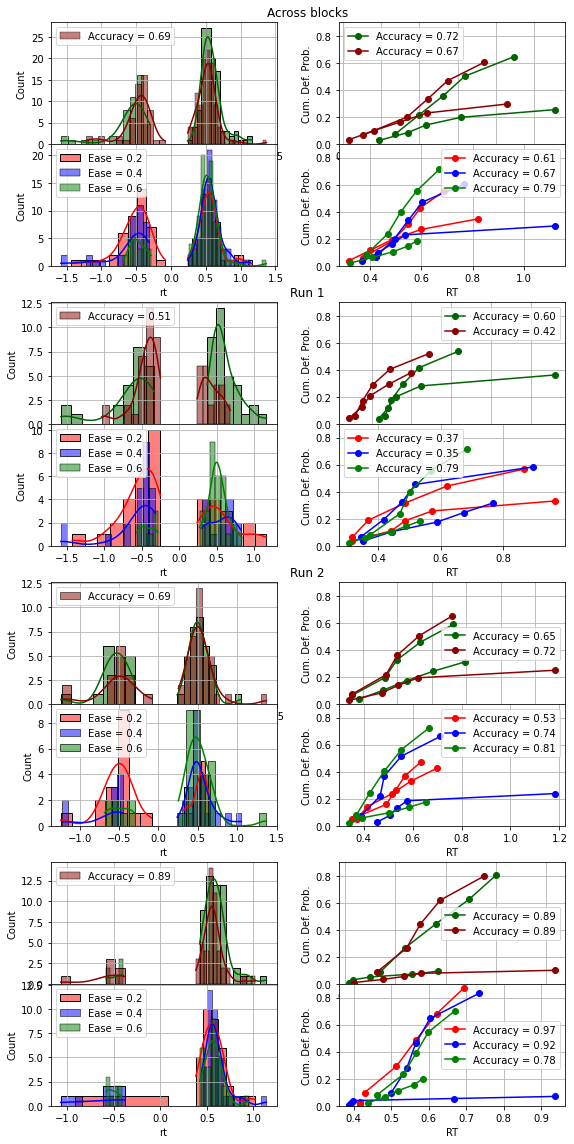

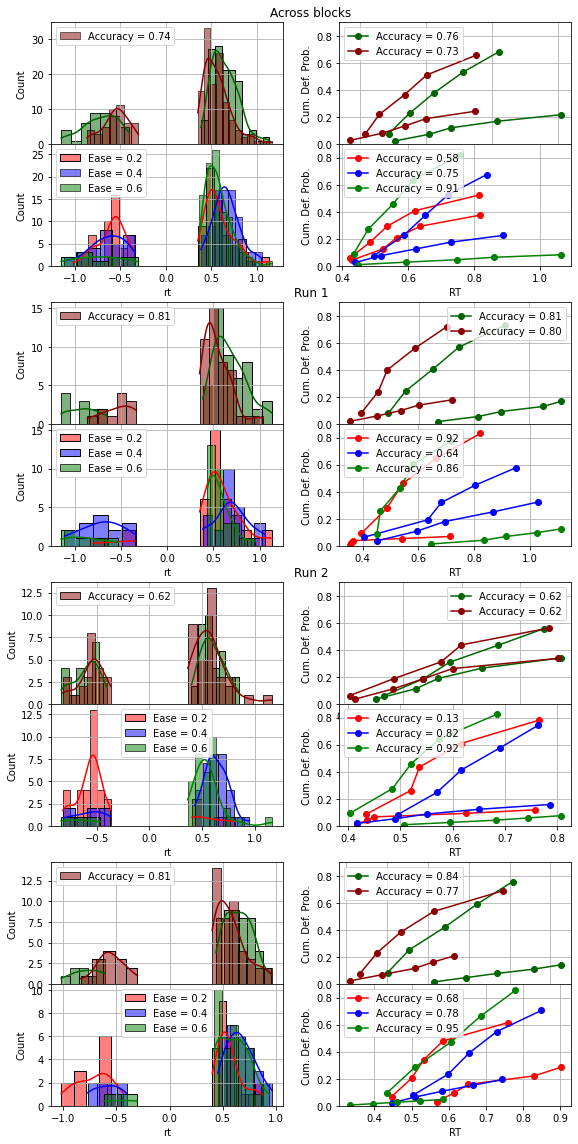

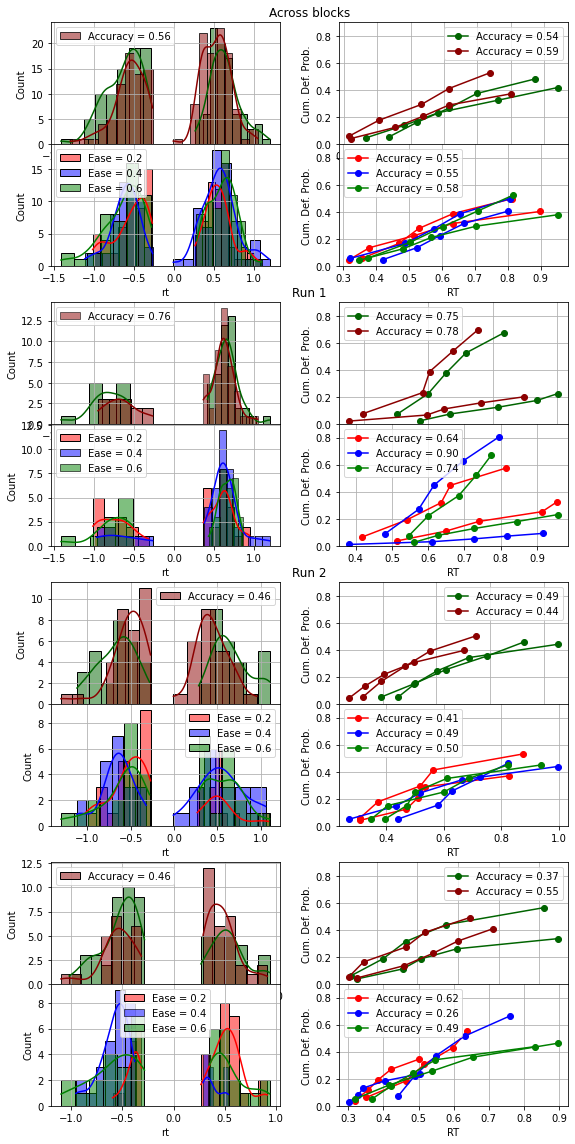

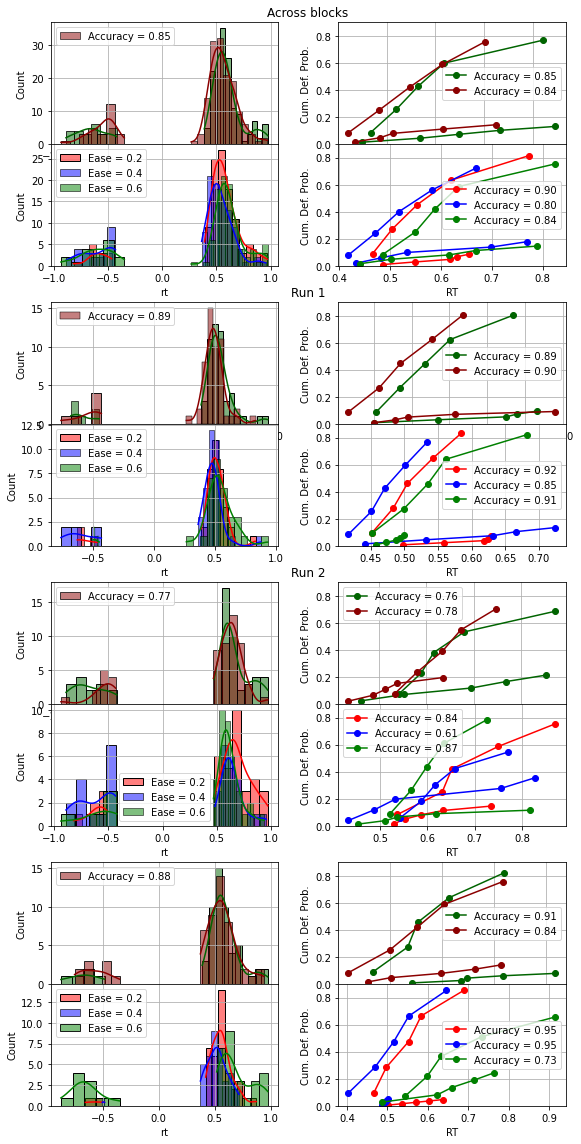

In [15]:
# run dat shit

# task names in the behavioral files are not the same as in the MRI data, so we need a mapping
task_name_mapping = {'sst': 'SST', 'msit': 'MSIT', 'rlsat': 'SAT-learning', 'rb': 'ReferenceBack', 'revl': 'reversal-learning'}

for sub, ses, task in to_process:
    
#     if sub=='009' and ses=='rbrevl': # fix this at some point
#         continue
    
    print(f'sub: {sub} ses: {ses} task: {task}')

    prepBehavior(sub=sub, ses=ses, task=task_name_mapping[task]).process()
    


In [211]:
# how many responses per subject and condition? 

for sub in range(2,20):
    print('\n')
    sub_id = str(sub).zfill(3)
    print('sub-'+sub_id)
    
    filename = Path('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')

    if filename.exists():

        dat = pd.read_csv('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')
        print('trials: ' +str(len(pd.unique(dat['trial_nr'])))+' \n')
        for trial_type in pd.unique(dat['trial_type']):
            print(trial_type)
            print(len(dat.loc[(dat['trial_type'] == trial_type)]))
            
    else:
        print('file not found')



sub-002
trials: 258 

nan
0
response_right
121
RefRepDifferent
32
response_left
122
ComSwiSame
32
ComRepDifferent
30
RefSwiSame
31
ComSwiDifferent
32
ComRepSame
28
RefSwiDifferent
30
RefRepSame
30
error
11


sub-003
trials: 258 

nan
0
response_left
121
RefRepDifferent
28
RefRepSame
31
response_right
135
ComSwiSame
31
ComRepSame
19
error
38
RefSwiDifferent
24
RefSwiSame
32
ComSwiDifferent
30
ComRepDifferent
23


sub-004
trials: 258 

nan
0
RefRepSame
32
response_right
129
RefRepDifferent
28
response_left
125
ComSwiDifferent
32
ComRepDifferent
28
RefSwiSame
31
ComSwiSame
30
RefSwiDifferent
27
ComRepSame
23
error
25


sub-005
trials: 258 

nan
0
RefRepSame
31
response_right
136
ComSwiDifferent
30
response_left
119
RefSwiSame
29
RefRepDifferent
31
RefSwiDifferent
25
ComSwiSame
32
ComRepSame
30
ComRepDifferent
27
error
21


sub-006
trials: 258 

nan
0
ComSwiSame
32
response_right
131
RefSwiDifferent
31
response_left
125
error
5
RefRepSame
31
ComRepDifferent
31
RefSwiSame
32
ComSwiDiffere

In [221]:
# how many trials per subject and condition? 

# if less than 64, because non-responses removed? why is number of trials still 258 then?


for sub in range(2, len(to_process)+2):
    print('\n')
    sub_id = str(sub).zfill(3)
    print('sub-'+sub_id)
    
    filename = Path('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')

    if filename.exists():

        dat = pd.read_csv('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')
        print('trials: ' +str(len(pd.unique(dat['trial_nr'])))+' \n')
        for trial_type in pd.unique(dat['condition']):
            print(trial_type)
            print(len(dat.loc[(dat['condition'] == trial_type)]))
            
    else:
        print('file not found')



sub-002
trials: 258 

nan
0
RefRepDifferent
63
ComSwiSame
63
ComRepDifferent
59
RefSwiSame
64
ComSwiDifferent
61
ComRepSame
62
RefSwiDifferent
63
RefRepSame
63


sub-003
trials: 258 

nan
0
RefRepDifferent
64
RefRepSame
63
ComSwiSame
64
ComRepSame
64
ComRepDifferent
64
RefSwiDifferent
64
RefSwiSame
64
ComSwiDifferent
64


sub-004
trials: 258 

nan
0
RefRepSame
64
RefRepDifferent
64
ComSwiDifferent
64
ComRepDifferent
64
RefSwiSame
64
ComSwiSame
64
RefSwiDifferent
62
ComRepSame
64


sub-005
trials: 258 

nan
0
RefRepSame
64
ComSwiDifferent
64
RefSwiSame
64
RefRepDifferent
64
RefSwiDifferent
64
ComSwiSame
63
ComRepSame
64
ComRepDifferent
64


sub-006
trials: 258 

nan
0
ComSwiSame
64
RefSwiDifferent
64
ComSwiDifferent
64
RefRepSame
64
ComRepDifferent
64
RefSwiSame
64
ComRepSame
64
RefRepDifferent
64


sub-007
trials: 258 

nan
0
ComSwiDifferent
64
ComRepDifferent
64
RefSwiSame
64
RefRepDifferent
64
ComRepSame
64
ComSwiSame
64
RefSwiDifferent
64
RefRepSame
64


sub-008
trials: 258 

nan


FileNotFoundError: [Errno 2] No such file or directory: '../derivatives/behavior/sub-021/ses-rbrevl/func/sub-021_ses-rbrevl_task-ReferenceBack_behavior.tsv'

In [231]:
# how many erros per subject?

# how many trials per subject and condition? 

# if less than 64, because non-responses removed? why is number of trials still 258 then?

from pathlib import Path

for sub in range(2, len(to_process)+2):
    #print('\n')
    sub_id = str(sub).zfill(3)
    print('sub-'+sub_id)
    filename = Path('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')

    if filename.exists():
        dat = pd.read_csv('../derivatives/behavior/sub-'+sub_id+'/ses-rbrevl/func/sub-'+sub_id+'_ses-rbrevl_task-ReferenceBack_behavior.tsv', sep='\t')
        for trial_type in pd.unique(dat['trial_type']):
            if trial_type == 'error':
                print(len(dat.loc[(dat['trial_type'] == trial_type)]))
                
    else:
        print('file not found')
    

sub-002
11
sub-003
38
sub-004
25
sub-005
21
sub-006
5
sub-007
7
sub-008
5
sub-009
45
sub-010
3
sub-011
21
sub-012
18
sub-013
91
sub-014
31
sub-015
18
sub-016
6
sub-017
20
sub-018
30
sub-019
5
sub-020
1
sub-021
file not found
sub-022
file not found
sub-023
22
sub-024
14
sub-025
21
sub-026
5
sub-027
44
sub-028
file not found
sub-029
11
sub-030
file not found
sub-031
11
sub-032
7
sub-033
5
sub-034
5
sub-035
6
sub-036
file not found
sub-037
5
sub-038
8


In [36]:
prepBehavior('003', 'rbrevl', 'ReferenceBack').process()


Processing sub 003 ses rbrevl task ReferenceBack
../sourcedata/zipdata/sub-003/ses-rbrevl/sub-003_ses-rbrevl_data_tmpunzip/sub-003_ses-rbrevl_data/RESOURCES/task_data/sub-003_ses-MRI_task-ReferenceBack_datetime-20210204-103207_block-1_events.tsv
../sourcedata/zipdata/sub-003/ses-rbrevl/sub-003_ses-rbrevl_data_tmpunzip/sub-003_ses-rbrevl_data/RESOURCES/task_data/sub-003_ses-MRI_task-ReferenceBack_datetime-20210204-103207_block-2_events.tsv


/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

NameError: name 'trials_with_responses' is not defined

In [38]:
prepBehavior('003', 'rbrevl', 'ReferenceBack').process()


Processing sub 003 ses rbrevl task ReferenceBack
../sourcedata/zipdata/sub-003/ses-rbrevl/sub-003_ses-rbrevl_data_tmpunzip/sub-003_ses-rbrevl_data/RESOURCES/task_data/sub-003_ses-MRI_task-ReferenceBack_datetime-20210204-103207_block-1_events.tsv
../sourcedata/zipdata/sub-003/ses-rbrevl/sub-003_ses-rbrevl_data_tmpunzip/sub-003_ses-rbrevl_data/RESOURCES/task_data/sub-003_ses-MRI_task-ReferenceBack_datetime-20210204-103207_block-2_events.tsv
sub 003 ses rbrevl task ReferenceBack processed


/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Processing sub 024 ses rbrevl task reversal-learning
../sourcedata/zipdata/sub-024/ses-rbrevl/sub-024_ses-rbrevl_data_tmpunzip/sub-024_ses-rbrevl_data/RESOURCES/task_data/sub-024_task-reversal-learning_datetime-20210826-142515_block-1_events.tsv
../sourcedata/zipdata/sub-024/ses-rbrevl/sub-024_ses-rbrevl_data_tmpunzip/sub-024_ses-rbrevl_data/RESOURCES/task_data/sub-024_task-reversal-learning_datetime-20210826-142515_block-2_events.tsv


/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/atrutti1/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


sub 024 ses rbrevl task reversal-learning processed


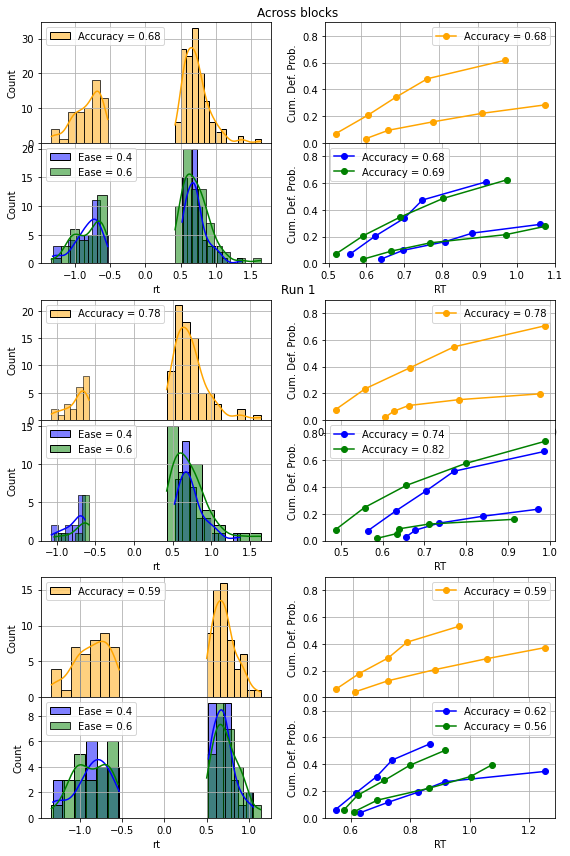

In [23]:
prepBehavior(sub='024', ses='rbrevl', task='reversal-learning').process()

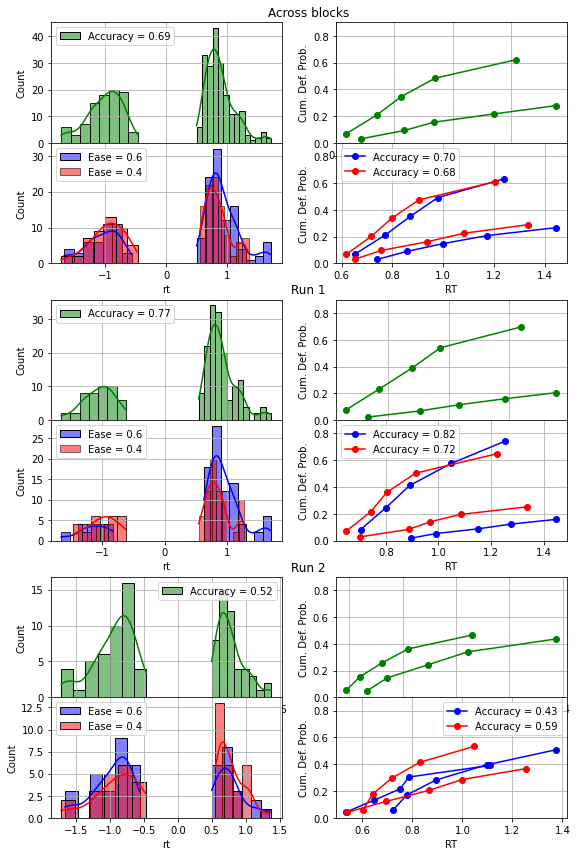

In [449]:
prepBehavior(sub='002', ses='wmrevl', task='reversal-learning').process()

### What about SSRTs in SST?

In [173]:
import pandas as pd
import numpy as np
import glob

#tmp = pd.read_csv('../derivatives/behavior/sub-002/ses-sstmsit/func/sub-002_ses-sstmsit_task-SST_behavior.tsv', sep='\t')

all_behavs = sorted(glob.glob('../derivatives/behavior/sub*/ses-sstmsit/func/sub*_ses-sstmsit_task-SST_*'))
dfs = []
for fn in all_behavs:
    dfs.append(pd.read_csv(fn, sep='\t'))
    
df = pd.concat(dfs)
df = df.rename(columns={'rt_y': 'rt'})
df.head(10)

,trial_nr,onset,event_type,phase,response,nr_frames,direction,stopsig_trial,jitter,block_nr,...,choice_key,onset_abs,duration,gender,age,session,correct_response_direction,has_response,trial_type,rt
0,0.0,5.669234,stimulus,1.0,NaN,72.0,1.0,1.0,1.5,1.0,...,NaN,46.683638,1.199944,na,na,1,1.0,True,fs,0.617625
1,0.0,6.286858,response,1.0,r,NaN,1.0,1.0,1.5,1.0,...,r,47.301262,NaN,na,na,1,1.0,True,response_left,0.617625
2,1.0,12.588032,stimulus,1.0,NaN,72.0,1.0,0.0,1.5,1.0,...,NaN,53.602435,1.199958,na,na,1,1.0,True,go,0.568469
3,1.0,13.156501,response,1.0,r,NaN,1.0,0.0,1.5,1.0,...,r,54.170905,NaN,na,na,1,1.0,True,response_left,0.568469
4,2.0,18.473179,stimulus,1.0,NaN,72.0,0.0,0.0,0.5,1.0,...,NaN,59.487583,1.199962,na,na,1,0.0,True,go,0.368566
5,2.0,18.841745,response,1.0,b,NaN,0.0,0.0,0.5,1.0,...,b,59.856149,NaN,na,na,1,0.0,True,response_right,0.368566
6,3.0,26.875760,stimulus,1.0,NaN,72.0,1.0,0.0,2.0,1.0,...,NaN,67.890164,1.199967,na,na,1,1.0,True,go,0.498991
7,3.0,27.374751,response,1.0,r,NaN,1.0,0.0,2.0,1.0,...,r,68.389155,NaN,na,na,1,1.0,True,response_left,0.498991
8,4.0,33.277719,stimulus,1.0,NaN,72.0,1.0,1.0,1.5,1.0,...,NaN,74.292123,1.199947,na,na,1,1.0,False,ss,NaN
9,5.0,40.196475,stimulus,1.0,NaN,72.0,0.0,1.0,1.5,1.0,...,NaN,81.210879,1.199987,na,na,1,0.0,True,fs,0.548339


In [174]:
responses = df.loc[df['event_type'] == 'response']
responses['correct_response'] = False
responses['response_direction'] = responses.trial_type.replace({'response_left': 1, 'response_right': 0})
responses.loc[(responses.trial_type == 'response_left') & (responses.correct_response_direction == 1), 'correct_response'] = True
responses.loc[(responses.trial_type == 'response_right') & (responses.correct_response_direction == 0), 'correct_response'] = True
responses

df = pd.merge(left=df, right=responses[['trial_nr', 'subject', 'correct_response', 'response_direction']], on=['trial_nr', 'subject'], how='outer')
df

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,trial_nr,onset,event_type,phase,response,nr_frames,direction,stopsig_trial,jitter,block_nr,...,duration,gender,age,session,correct_response_direction,has_response,trial_type,rt,correct_response,response_direction
0,0.0,5.669234,stimulus,1.0,NaN,72.0,1.0,1.0,1.5,1.0,...,1.199944,na,na,1,1.0,True,fs,0.617625,True,1.0
1,0.0,6.286858,response,1.0,r,NaN,1.0,1.0,1.5,1.0,...,NaN,na,na,1,1.0,True,response_left,0.617625,True,1.0
2,1.0,12.588032,stimulus,1.0,NaN,72.0,1.0,0.0,1.5,1.0,...,1.199958,na,na,1,1.0,True,go,0.568469,True,1.0
3,1.0,13.156501,response,1.0,r,NaN,1.0,0.0,1.5,1.0,...,NaN,na,na,1,1.0,True,response_left,0.568469,True,1.0
4,2.0,18.473179,stimulus,1.0,NaN,72.0,0.0,0.0,0.5,1.0,...,1.199962,na,na,1,0.0,True,go,0.368566,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575,218.0,744.477584,stimulus,1.0,NaN,72.0,1.0,1.0,2.0,2.0,...,1.199639,na,na,1,1.0,False,ss,NaN,NaN,NaN
8576,219.0,750.377557,stimulus,1.0,NaN,72.0,1.0,0.0,1.0,2.0,...,1.199600,na,na,1,1.0,True,go,0.748628,True,1.0
8577,219.0,751.126185,response,1.0,r,NaN,1.0,0.0,1.0,2.0,...,NaN,na,na,1,1.0,True,response_left,0.748628,True,1.0
8578,220.0,756.777574,stimulus,1.0,NaN,72.0,1.0,0.0,0.5,2.0,...,1.199515,na,na,1,1.0,True,go,0.932508,True,1.0


In [175]:
df = df.loc[df.event_type == 'stimulus']

In [176]:
exclude_for_RT_idx = (((np.in1d(df['trial_type'], ['go', 'fs'])) & (df['rt'] > 1.2)) |
                      ((np.in1d(df['trial_type'], ['go', 'fs'])) & (df['rt'] < .15)) |
                      ((np.in1d(df['trial_type'], ['go', 'fs'])) & (pd.isnull(df['rt']))))
print('Excluding {:.3f}% of go trials based on RT'.format(exclude_for_RT_idx.sum()/df.shape[0]))

# How many errors?
error_trial = (np.in1d(df['trial_type'], ['go', 'fs']) & (df['correct_response']==False))
print('{:.3f}% of trials were errors'.format(error_trial.sum()/df.shape[0]*100))

Excluding 0.007% of go trials based on RT
0.624% of trials were errors


In [177]:
df.loc[df['current_ssd']<0, 'current_ssd'] = np.nan

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [179]:
df.groupby(['subject', 'block_nr']).current_ssd.first()

subject  block_nr
2.0      1.0         0.20
         2.0         0.35
3.0      1.0         0.20
         2.0         0.40
4.0      1.0         0.20
         2.0         0.45
5.0      1.0         0.20
         2.0         0.35
6.0      1.0         0.20
         2.0         0.25
7.0      1.0         0.20
         2.0         0.65
8.0      1.0         0.20
         2.0         0.80
9.0      1.0         0.20
         2.0         0.45
10.0     1.0         0.20
         2.0         0.85
11.0     1.0         0.20
         2.0         0.35
12.0     1.0         0.20
         2.0         0.55
13.0     1.0         0.20
         2.0         0.65
14.0     1.0         0.20
         2.0         0.55
15.0     1.0         0.20
         2.0         0.45
16.0     1.0         0.20
         2.0         0.25
17.0     1.0         0.20
         2.0         0.35
18.0     1.0         0.20
         2.0         0.05
19.0     1.0         0.20
         2.0         0.85
20.0     1.0         0.20
         2.0        

In [156]:
def get_ssrt(x):
    failed_stop_rate = np.sum(x.trial_type=='fs') / np.sum(x.stopsig_trial==1)
    # mean SSD
#    mean_ssd = x.loc[x.current_ssd>-1, 'ssd'].mean()/1000
    mean_ssd = x.current_ssd.mean(skipna=True) #/1000  # to s
    # go RT at failed_stop_rate percentile
    go_rt_at_percentile = np.percentile(x.loc[(x.trial_type=='go') & pd.notnull(x.rt) & (x.correct_response==True), 'rt'], failed_stop_rate*100)
    ssrt = go_rt_at_percentile - mean_ssd
    return ssrt
    
def get_descriptives(x):
    mean_go_rt = x.loc[(x.trial_type=='go') & (pd.notnull(x.rt)), 'rt'].mean()
    median_go_rt = np.median(x.loc[(x.trial_type=='go') & (pd.notnull(x.rt)), 'rt'])
    
    mean_failed_stop_rt = x.loc[x.trial_type=='fs', 'rt'].mean()
    median_failed_stop_rt = np.median(x.loc[x.trial_type=='fs', 'rt'])
    
    # SSRT
    ssrt = get_ssrt(x)
#     failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')
#     # mean SSD
    
    mean_ssd = x.current_ssd.mean(skipna=True) #/1000  # to s
#     # go RT at failed_stop_rate percentile
#     go_rt_at_percentile = np.percentile(x.loc[(x.trial_type=='go') & pd.notnull(x.rt) & (x.correct_response==True), 'rt'], failed_stop_rate*100)
#     ssrt = go_rt_at_percentile - mean_ssd

    # accuracy
    accuracy = x.loc[x.trial_type == 'go', 'correct_response'].mean() #(x.trial_type=='go_trial').sum() / ( (x.event_type=='go_trial').sum() + (x.event_type=='go_error').sum() )
    
    failed_stop_rate = np.sum(x.trial_type=='fs') / np.sum(x.stopsig_trial==1)
    
    misses = np.sum((x.trial_type=='go') & (pd.isnull(x.response_direction))) / np.sum(x.trial_type=='go')
    
    out = pd.Series({'Median go RT': median_go_rt,
                     'Mean go RT': mean_go_rt,
                     'Median failed stop RT': median_failed_stop_rt,
                     'Mean failed stop RT': mean_failed_stop_rt,
                     'SSD': mean_ssd,
                     'SSRT': ssrt,
                     'Go accuracy': accuracy,
                     'Perc. inhibition': 1-failed_stop_rate,
                     'Misses (go)': misses})
    return out
    
aggregated_per_run = df.groupby(['subject', 'block_nr']).apply(get_descriptives)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(aggregated_per_run)

Median go RT  Mean go RT  Median failed stop RT  \
subject block_nr                                                    
2.0     1.0           0.585369    0.600809               0.498957   
        2.0           0.539173    0.564173               0.474314   
3.0     1.0           0.585150    0.598767               0.476193   
        2.0           0.668830    0.681466               0.554964   
4.0     1.0           0.769690    0.726836               0.566706   
        2.0           0.881927    0.875017               0.616504   
5.0     1.0           0.484677    0.543398               0.436976   
        2.0           0.651427    0.683081               0.598658   
6.0     1.0           0.504621    0.517970               0.492623   
        2.0           0.584273    0.589765               0.485957   
7.0     1.0           0.735541    0.733042               0.642453   
        2.0           0.770646    0.798371               0.782388   
8.0     1.0           0.850301    0.845368               0.826377   
        2.0           1.001680    0.996929               0.967762   
9.0     1.0           0.600198    0.606089               0.484337   
        2.0           0.634590    0.649978               0.543134   
10.0    1.0           0.776834    0.830901               0.856151   
        2.0           1.017636    0.975605               0.890611   
11.0    1.0           0.684141    0.687170               0.653961   
        2.0           0.659309    0.655651               0.536265   
12.0    1.0           0.732408    0.722369               0.650871   
        2.0           0.786915    0.799973               0.667212   
13.0    1.0           0.717933    0.723592               0.658470   
        2.0           0.732782    0.721035               0.785754   
14.0    1.0           0.749020    0.756937               0.671570   
        2.0           0.951984    0.953525               0.833512   
15.0    1.0           0.618341    0.631240               0.463736   
        2.0           0.725855    0.661294               0.417264   
16.0    1.0           0.517133    0.504433               0.445682   
        2.0           0.489651    0.507585               0.470403   
17.0    1.0           0.681410    0.664149               0.570102   
        2.0           0.798920    0.811612               0.733166   
18.0    1.0           0.554219    0.595873               0.461022   
        2.0           0.582580    0.595169               0.509921   
19.0    1.0           0.809934    0.802103               0.698352   
        2.0           1.051532    1.040757               1.016779   
20.0    1.0           0.665285    0.666946               0.583912   
        2.0           0.682261    0.685925               0.617373   
21.0    1.0           0.719053    0.704909               0.652510   
        2.0           0.900407    0.890501               0.786223   
23.0    1.0           0.387039    0.394283               0.384038   
        2.0           0.385010    0.396343               0.360216   
24.0    1.0           0.780465    0.789373               0.591553   
        2.0           0.868271    0.881263               0.833594   
26.0    1.0           0.862602    0.816989               0.708741   
        2.0           0.905076    0.906354               0.821411   

                  Mean failed stop RT    SSD      SSRT  Go accuracy  \
subject block_nr                                                      
2.0     1.0                  0.516229  0.228  0.338507     1.000000   
        2.0                  0.491607  0.254  0.279870     1.000000   
3.0     1.0                  0.496664  0.312  0.243484     1.000000   
        2.0                  0.539189  0.416  0.267233     1.000000   
4.0     1.0                  0.612073  0.440  0.219119     1.000000   
        2.0                  0.631937  0.538  0.312272     1.000000   
5.0     1.0                  0.448815  0.244  0.223705     0.951220   
        2.0                  0.575309  0.414  0.223164     1.00000

In [157]:
aggregated = df.groupby(['subject']).apply(get_descriptives).reset_index()

aggregated

,subject,Median go RT,Mean go RT,Median failed stop RT,Mean failed stop RT,SSD,SSRT,Go accuracy,Perc. inhibition,Misses (go)
0,2.0,0.559842,0.582491,0.483071,0.503383,0.241,0.308265,1.000000,0.54,0.0
1,3.0,0.617411,0.639839,0.518423,0.520700,0.364,0.237313,1.000000,0.54,0.0
2,4.0,0.835072,0.797705,0.606777,0.622005,0.489,0.310231,1.000000,0.60,0.0
3,5.0,0.605406,0.611402,0.484695,0.512062,0.329,0.254763,0.974359,0.56,0.0
4,6.0,0.542663,0.553868,0.485957,0.494509,0.285,0.249207,1.000000,0.52,0.0
5,7.0,0.752140,0.765040,0.665782,0.689178,0.543,0.183493,1.000000,0.62,0.0
6,8.0,0.949365,0.920587,0.903321,0.868231,0.654,0.247636,0.992593,0.62,0.0
7,9.0,0.621930,0.627733,0.523469,0.523905,0.357,0.261306,1.000000,0.52,0.0
8,10.0,0.885517,0.897444,0.863545,0.868867,0.663,0.159654,1.000000,0.60,0.0
9,11.0,0.665113,0.671516,0.586160,0.599051,0.405,0.258366,0.973856,0.54,0.0


In [158]:
aggregated['Error rate'] = (1-aggregated['Go accuracy'])*100
aggregated['Perc. inhibition'] *= 100
means = aggregated.mean()
stds = aggregated.std()


table1 = pd.concat([means, stds], axis=1).T
table1.index = ['mean', 'SD']
# table1.index = ['mean', 'SD']

# 
table1 = table1[['Median go RT', 'Mean go RT', 'Median failed stop RT', 'Mean failed stop RT', 'SSD', 'SSRT', 'Go accuracy', 'Perc. inhibition', 'Error rate']]
table1
# #table1 = pd.DataFrame(index=[0], columns=means.columns)
# for row in range(means.shape[0]):
#     for col in range(means.shape[1]):
#         table1.iloc[row, col] = '{:.2f} ({:.2f})'.format(means.iloc[row, col], stds.iloc[row, col])
# #table1 = table1.reindex(['se', 'me'])
# table1 = table1[['Median go RT', 'Mean failed stop RT', 'Error rate', 'SSRT', 'SSD', 'Perc. inhibition']]
# # table1.to_csv('figures/table_behavior.tsv', sep='\t')
# table1

,Median go RT,Mean go RT,Median failed stop RT,Mean failed stop RT,SSD,SSRT,Go accuracy,Perc. inhibition,Error rate
mean,0.711259,0.711047,0.632304,0.632098,0.445826,0.234945,0.992900,57.130435,0.709987
SD,0.149300,0.138137,0.158671,0.137643,0.155765,0.058259,0.017405,5.353880,1.740535


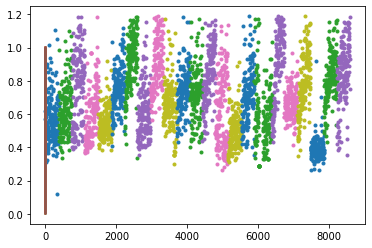

In [152]:
all_subs = df.subject.unique()

for subj in df.subject.unique():
    idx = df.subject == subj
    plt.plot(df.loc[idx].index, df.loc[idx, 'rt'], '.', m.to_rgba(subj))
    
#     break

In [139]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=25)
cmap = cm.prism

m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))

In [143]:
m.to_rgba(df.subject)

array([[0.41420859, 0.        , 0.99646076, 1.        ],
       [0.41420859, 0.        , 0.99646076, 1.        ],
       [0.41420859, 0.        , 0.99646076, 1.        ],
       ...,
       [0.32950713, 0.99825489, 0.        , 1.        ],
       [0.32950713, 0.99825489, 0.        , 1.        ],
       [0.32950713, 0.99825489, 0.        , 1.        ]])

In [181]:
from scipy import stats
print(stats.pearsonr(aggregated['Median go RT'],
                     aggregated['SSRT']))

(-0.3556125933038296, 0.09585322243356652)


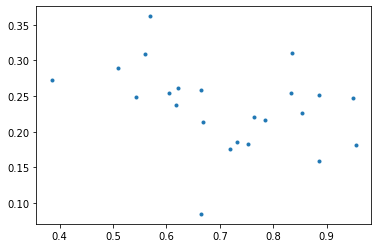

In [182]:
plt.plot(aggregated['Median go RT'], aggregated['SSRT'], '.')

In [140]:

plt.plot(df.rt, '.', color=m.to_rgba(df.subject))

ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

In [136]:
all_subs

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 23., 24., 26.])

# --------- OLD --------

In [ ]:
to_process = [('002', 'rlsat', 'SAT-learning'),
              ('002', 'rbrevl', 'reversal-learning'),
              ('002', 'rbrevl', 'ReferenceBack')
]

to_process = [
              ('002', 'sstmsit', 'SST'),
#               ('002', 'sstmsit', 'MSIT'),
              ('003', 'sstmsit', 'SST'),
#               ('003', 'sstmsit', 'MSIT'),
              ('004', 'sstmsit', 'SST'),
#               ('004', 'sstmsit', 'MSIT'),
#               #('005', 'rlsat', 'SAT-learning'),
              ('006', 'sstmsit', 'SST'),
#               ('006', 'sstmsit', 'MSIT'),
#               ('006', 'rbrevl', 'ReferenceBack'),
#               ('006', 'rbrevl', 'reversal-learning'),
#               ('005', 'rbrevl', 'ReferenceBack'),
#               ('005', 'rbrevl', 'reversal-learning'),
#               ('008', 'rlsat', 'SAT-learning'),
#               #('008', 'rbrevl', 'ReferenceBack'),
#               #('004', 'sstmsit', 'MSIT'),
#               #('006', 'rlsat', 'SAT-learning')
#               ('007', 'rlsat', 'SAT-learning'),
              ('009', 'sstmsit', 'MSIT'),
              ('009', 'sstmsit', 'SST'),
#               ('011', 'rlsat', 'SAT-learning')
#                 ('003', 'rlsat', 'SAT-learning'),
                ('005', 'sstmsit', 'MSIT'),
                ('005', 'sstmsit', 'SST'),
                ('007', 'sstmsit', 'MSIT'),
                ('007', 'sstmsit', 'SST'),
                ('005', 'sstmsit', 'MSIT'),
                ('005', 'sstmsit', 'SST'),
                ('007', 'sstmsit', 'MSIT'),
                ('007', 'sstmsit', 'SST'),
                ('008', 'sstmsit', 'MSIT'),
                ('008', 'sstmsit', 'SST'),
                ('010', 'sstmsit', 'MSIT'),
                ('010', 'sstmsit', 'SST'),
                ('015', 'sstmsit', 'MSIT'),
                ('015', 'sstmsit', 'SST'),
#                 ('010', 'rbrevl', 'ReferenceBack'),
#                 ('010', 'rbrevl', 'reversal-learning'),
                ('012', 'sstmsit', 'SST'),
                ('012', 'sstmsit', 'MSIT'),
#                 ('012', 'rlsat', 'SAT-learning'),
                ('013', 'sstmsit', 'MSIT'),
                ('013', 'sstmsit', 'SST'),
#                 ('014', 'rbrevl', 'ReferenceBack'),
#                 ('014', 'rbrevl', 'reversal-learning'),
#                 ('015', 'rbrevl', 'ReferenceBack'),
#                 ('015', 'rbrevl', 'reversal-learning'),
#                 ('016', 'rlsat', 'SAT-learning'),
                ('016', 'sstmsit', 'MSIT'),
                ('016', 'sstmsit', 'SST'),
#                 ('017', 'rlsat', 'SAT-learning'),
#                 ('017', 'rbrevl', 'ReferenceBack'),
#                 ('017', 'rbrevl', 'reversal-learning'),
#                 ('018', 'rlsat', 'SAT-learning'),
                ('019', 'sstmsit', 'MSIT'),
                ('019', 'sstmsit', 'SST'),
#                 ('020', 'rbrevl', 'ReferenceBack'),
#                 ('020', 'rbrevl', 'reversal-learning')
    
             ]
    
#     #del_tmp(sub,ses)